In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import smplotlib
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14
    
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.io import fits
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nuwa.wlkernel import make_graph, calculate_grakel_graph, GaussianProcess
import multiprocessing
import os
from grakel import Graph
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from scipy.sparse import lil_matrix
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree
np.set_printoptions(suppress=True)


In [16]:
n_train = 500
n_star  = 2000

data_dir = "/nfsdata/users/jdli_ny/wlkernel/mock/"
data = np.load(data_dir+f'binary_train_flatZ_abg_{n_train}tr_{n_star}cmd.npz')
# data = np.load(data_dir+f'binary_train_flatZ_abg_mesh_{n_star}cmd.npz')

# Split X and Y into training and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(
    data['X'], data['Y'], test_size=0.1, random_state=42
)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


for d in [X_train, X_test, Y_train, Y_test]:

    print(len(d[np.isnan(d)]))
    # d = d[~np.isnan(d).any(axis=1)]
    print(d.shape)

(450, 2000, 2) (50, 2000, 2) (450, 3) (50, 3)
0
(450, 2000, 2)
0
(50, 2000, 2)
0
(450, 3)
0
(50, 3)


# train

In [17]:
num_cpu = 24
radius  = 0.1
subsample_factor = 1
n_iter = 3

# Make the graph objects for all realisations in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    graph_list, degree_list = zip(*pool.map(make_graph, tqdm([(i, X_train[i], radius, subsample_factor) for i in range(X_train.shape[0])])))

    
# Initialize the grakel graph kernel
wl_kernel = WeisfeilerLehman(n_iter=n_iter, base_graph_kernel=VertexHistogram)
args_list = [(i, graph_list[i], degree_list[i]) for i in range(len(graph_list))]


# Calculate grakel graphs in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    grakel_list = list(tqdm(pool.imap(calculate_grakel_graph, args_list), total=len(graph_list)))



100%|██████████| 450/450 [00:43<00:00, 10.31it/s]


[[0.71829198 0.42190205 0.78674986 ... 0.75161209 0.54629977 0.78003823]
 [0.42190205 0.40814339 0.4301897  ... 0.42587998 0.41736872 0.42446985]
 [0.78674986 0.4301897  1.         ... 0.90906665 0.6005013  0.94600404]
 ...
 [0.75161209 0.42587998 0.90906665 ... 0.8911281  0.57703765 0.89223889]
 [0.54629977 0.41736872 0.6005013  ... 0.57703765 0.54624207 0.58808425]
 [0.78003823 0.42446985 0.94600404 ... 0.89223889 0.58808425 0.96371177]]
0.0
558624.5692337493


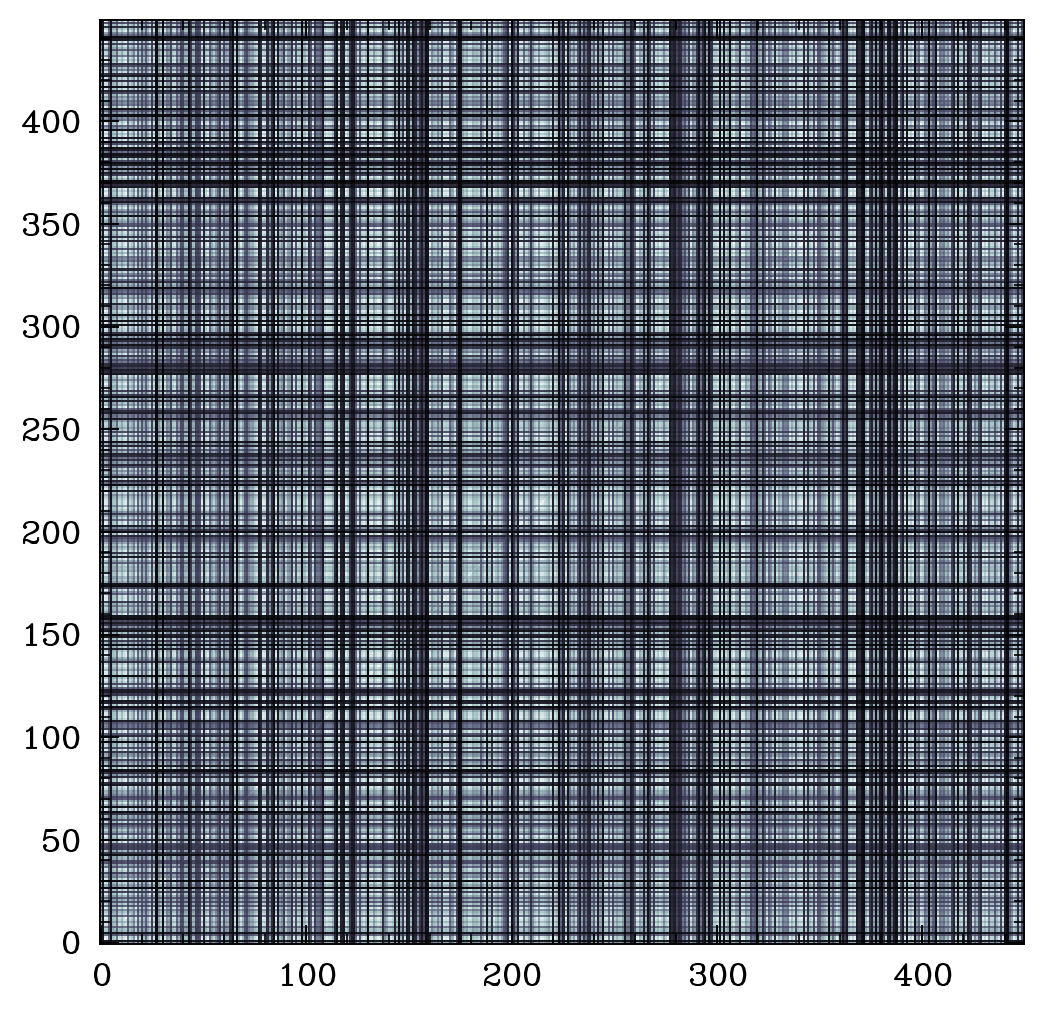

In [18]:
# Normalize kernel values
kernel_values = wl_kernel.fit_transform(grakel_list)
kernel_values = kernel_values / np.max(kernel_values)

print(kernel_values)
print(np.linalg.det(kernel_values))
print(np.linalg.cond(kernel_values))

plt.imshow(kernel_values, cmap='bone')


# validation

In [19]:
# Make the graph objects for all realisations in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    graph_list, degree_list = zip(*pool.map(make_graph, tqdm([(i, X_test[i], radius, subsample_factor) for i in range(X_test.shape[0])])))

    
# wl_kernel = WeisfeilerLehman(n_iter=n_iter, base_graph_kernel=VertexHistogram)
args_list = [(i, graph_list[i], degree_list[i]) for i in range(len(graph_list))]


# Calculate grakel graphs in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    grakel_list_test = list(tqdm(pool.imap(calculate_grakel_graph, args_list), total=len(graph_list)))


# Normalize kernel values
K_star = wl_kernel.transform(grakel_list_test)
K_star = K_star / np.max(K_star)

100%|██████████| 50/50 [00:05<00:00,  9.04it/s]


In [20]:
class GaussianProcess:
    
    def __init__(self, K, K_star, K_star_star=None):
        # self.kernel = kernel
        self.K = K
        self.K_star = K_star
        # self.K_star_star = K_star_star
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self):
        self.K_inv = np.linalg.inv(self.K)
        mu = self.K_star @ self.K_inv @ self.y_train
        # cov = self.K_star_star - self.K_star @ self.K_inv @ self.K_star
        return mu
    

gp = GaussianProcess(kernel_values, K_star)
gp.fit(X_train, Y_train)

y_pred = gp.predict()
y_pred

array([[ 2.12715389,  0.3482918 ,  1.34983533],
       [ 2.63556117,  0.4193767 ,  0.27802735],
       [ 0.69656844,  0.32862371, -0.41861681],
       [ 1.12016997,  0.24914156,  1.39948674],
       [ 2.75845454,  0.41299616,  0.94434272],
       [ 1.34747277,  0.73976966,  2.88299747],
       [ 0.70783247,  0.62065712, -0.06878712],
       [ 1.08453144,  0.51523613,  0.85439382],
       [ 0.74125703,  0.53753024,  1.19703373],
       [ 2.5246831 ,  0.46173937, -0.52969524],
       [ 2.35419592,  0.52545874,  0.5653712 ],
       [ 1.34145448,  0.62076073,  1.07632317],
       [ 1.45930539,  0.67334375,  1.51081657],
       [ 1.16782471,  0.23878105, -1.08805048],
       [ 0.70323427,  0.56528676,  0.47117756],
       [ 2.44588978,  0.19697991,  0.86794418],
       [ 1.35899865,  0.6209706 ,  1.09085629],
       [ 2.06360659,  0.43823255,  0.74327347],
       [ 1.50550637,  0.41345319, -0.38069762],
       [ 2.80904478,  0.22143531,  3.01746832],
       [ 1.61875706,  0.62987481,  1.900

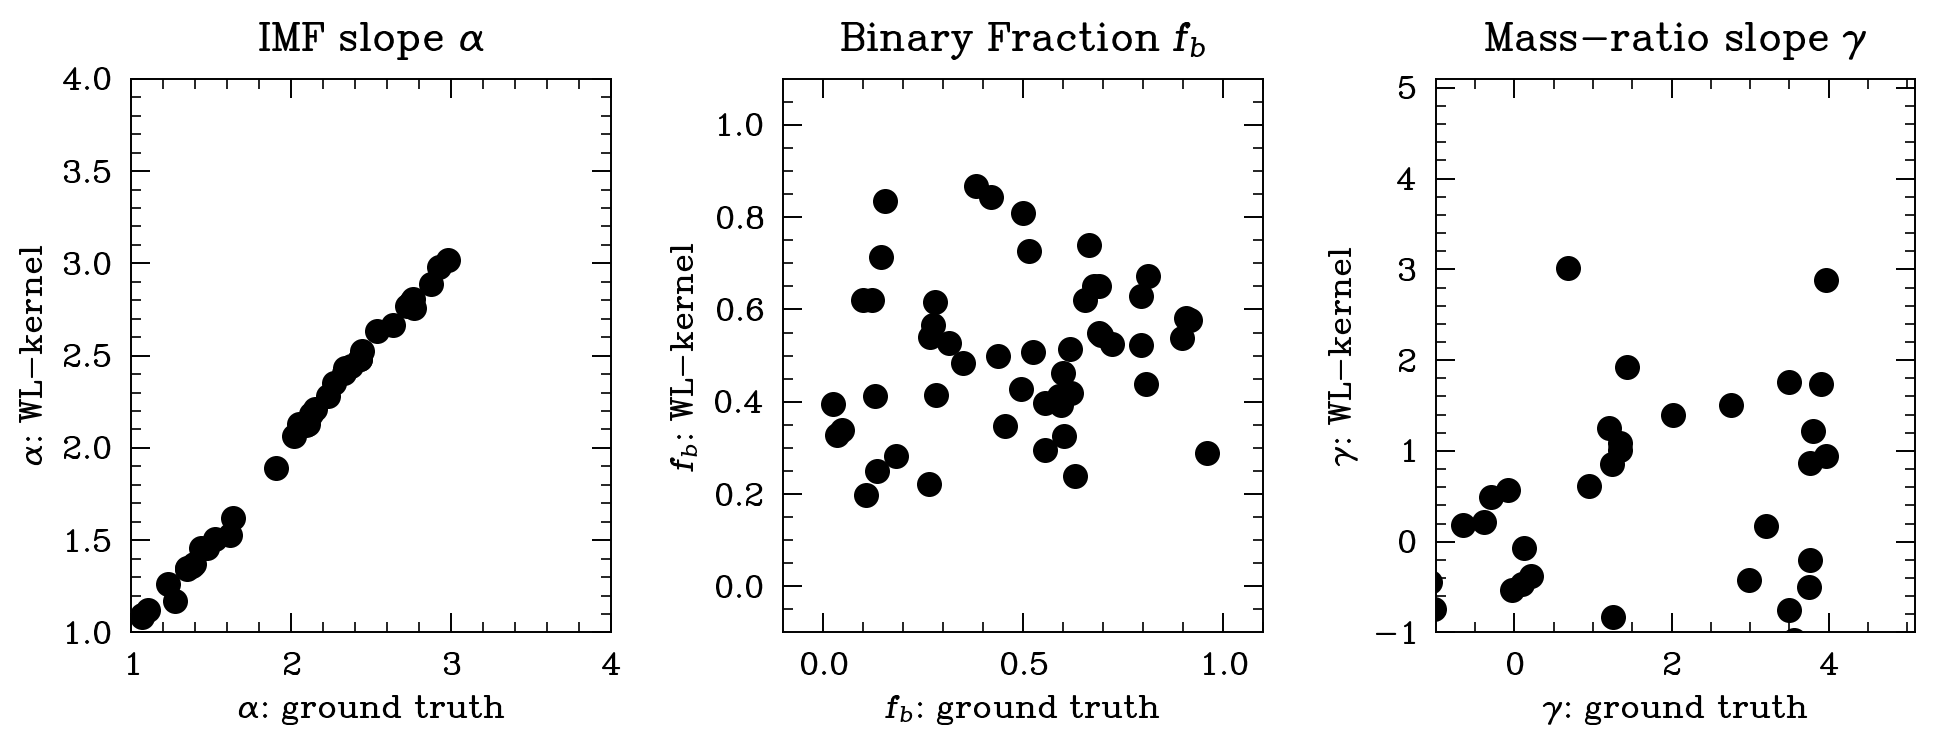

In [21]:
# Create one-to-one comparison plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4))

ax1.scatter(Y_test[:,0], y_pred[:,0], )
ax2.scatter(Y_test[:,1], y_pred[:,1], )
ax3.scatter(Y_test[:,2], y_pred[:,2], )

ax1.set_xlim(1., 4.);
ax1.set_ylim(1., 4.);
ax1.set_xlabel(r"$\alpha$: ground truth");
ax1.set_ylabel(r"$\alpha$: WL-kernel");


ax2.set_xlim(-0.1, 1.1);
ax2.set_ylim(-0.1, 1.1);
ax2.set_xlabel(r"$f_b$: ground truth");
ax2.set_ylabel(r"$f_b$: WL-kernel");


ax3.set_xlim(-1, 5.1);
ax3.set_ylim(-1, 5.1);
ax3.set_xlabel(r"$\gamma$: ground truth");
ax3.set_ylabel(r"$\gamma$: WL-kernel");

ax1.set_title(r'IMF slope $\alpha$')
ax2.set_title(r'Binary Fraction $f_b$')
ax3.set_title(r'Mass-ratio slope $\gamma$')

plt.tight_layout()

In [64]:
import pickle

model_dir = "/nfsdata/users/jdli_ny/wlkernel/model/"

with open(model_dir+'wl_kernel.pkl', 'wb') as f:
    pickle.dump(wl_kernel, f)


np.save(model_dir+"kernel_values_flatZ.npy", kernel_values)